# Learning PyTorch

## Prepare Data

In [1]:
%matplotlib inline
from random import choice, randrange
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import random

EOS = "<EOS>" #all strings will end with the End Of String token
PAD = "<PAD>"
characters = list("abcd")
characters.append(EOS)
characters.append(PAD)

int2char = list(characters)
char2int = {c:i for i,c in enumerate(characters)}

VOCAB_SIZE = len(characters)
PAD_IDX = VOCAB_SIZE - 1

def sample_model(min_length, max_lenth):
    random_length = randrange(min_length, max_lenth)                             # Pick a random length
    random_char_list = [choice(characters[:-2]) for _ in range(random_length)]  # Pick random chars
    random_string = ''.join(random_char_list) 
    return random_string, random_string[::-1]  # Return the random string and its reverse
    

MIN_STRING_LEN = 1
MAX_STRING_LEN = 10
TRAIN_SET_SIZE = 5000
VAL_SET_SIZE = 10

batch_size = 64

RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
STATE_SIZE = 64

default_epochs = 50

use_gpu = False

train_set = [sample_model(MIN_STRING_LEN, MAX_STRING_LEN) for _ in range(TRAIN_SET_SIZE)]
val_set = [sample_model(MIN_STRING_LEN, MAX_STRING_LEN) for _ in range(VAL_SET_SIZE)]

## PyTorch

### Helpers

In [2]:
def _preprocess_string(strings):
    batch_size = len(strings)

    strings_with_eos = [list(string) + [EOS] for string in strings]
    max_len = max([len(string) for string in strings_with_eos])
    padded_strings = [string + [PAD] * (max_len - len(string)) for string in strings_with_eos]
    #len_first = [[padded_strings[j][i]for j in range(batch_size)] for i in range(max_len)]
    #int_strings = [[char2int[c] for c in string] for string in len_first]
    int_strings = [[char2int[c] for c in string] for string in padded_strings]
    var = Variable(torch.LongTensor(int_strings))
    if use_gpu: return var.cuda()
    return var

def get_loss(network, input_strings, output_strings):
    batch_size = len(output_strings)
    input_strings_t = _preprocess_string(input_strings)
    output_strings_t = _preprocess_string(output_strings)

    probs = network(input_strings_t, batch_size).permute(1, 0, 2)

    loss = sum([F.cross_entropy(p, t, ignore_index=PAD_IDX) for p, t in zip(probs, output_strings_t)])

    return loss

def generate(network, input_string):
    input_string = _preprocess_string([input_string])
    probs = network(input_string, 1)
    generated = [int2char[prob[0].topk(1)[1][0]] for prob in probs.data]
    return (''.join(generated)).split(EOS)[0].replace(PAD, '')

def batcher(dataset, epochs = 1):
    sources, targets = [], []
    i = 0
    for _ in range(epochs):
        for source, target in dataset:
            i+=1
            sources.append(source), targets.append(target)
            if len(sources) >= batch_size:
                yield sources, targets
                sources, targets = [], []
    if sources: yield sources, targets

In [3]:
def train(network, train_set, val_set, epochs=default_epochs):
    def get_val_set_loss(network, val_set):
        losses = [get_loss(network, input_strings, output_strings).data[0]
                 for input_strings, output_strings in batcher(val_set)]
        return sum(losses)
    if use_gpu: network.cuda()
    losses = []
    iterations = []
    optim = torch.optim.Adam(network.parameters())
    
    total_iterations = max(int((len(train_set)*epochs)/batch_size), 100)
    for i, (input_strings, output_strings) in enumerate(tqdm(batcher(train_set, epochs=epochs))):
              
        optim.zero_grad()
        loss = get_loss(network, input_strings, output_strings)
        loss.backward()
        optim.step()
            
        # Accumulate average losses over training to plot
        if i%int(total_iterations/100) == 0:
            val_loss = get_val_set_loss(network, val_set)
            losses.append(val_loss)
            iterations.append(i/((len(train_set)/100)))

    plt.plot(iterations, losses)
    #plt.axis([0, 100, 0, 100])
    plt.show() 
    print('loss on validation set:', val_loss)

### LSTM

In [4]:
class SimpleRNNNetwork(nn.Module):
    def __init__(self,num_of_layers, embeddings_size, state_size):
        super(SimpleRNNNetwork, self).__init__()
        self.num_of_layers = num_of_layers
        self.state_size = state_size
        
        # the embedding paramaters
        self.embeddings = nn.Embedding(VOCAB_SIZE, embeddings_size, padding_idx=PAD_IDX)

        # the rnn
        self.RNN = nn.LSTM(embeddings_size, state_size, num_of_layers)
        
        # project the rnn output to a vector of VOCAB_SIZE length
        self.linear = nn.Linear(state_size, VOCAB_SIZE)    
        
    def lstm_init_func(self, batch_size):
        h0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        c0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        if use_gpu: return h0.cuda(), c0.cuda()
        return h0,c0
    
    def forward(self, input_string, batch_size):                        
        embedded = self.embeddings(input_string.permute(1, 0))
        output, hn = self.RNN(embedded, self.lstm_init_func(batch_size))
        output = output
        logits = self.linear(output)
        return logits #F.log_softmax(logits, 2)   

In [5]:
#lstm_net = SimpleRNNNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
#train(lstm_net, train_set, val_set)
#print(generate(lstm_net, 'abc'))

### encoder-decoder

In [6]:
class EncoderDecoderNetwork(nn.Module):
    def __init__(self, num_of_layers, embeddings_size, state_size):
        super(EncoderDecoderNetwork, self).__init__()
        self.num_of_layers = num_of_layers
        self.state_size = state_size
        
        self.embeddings = nn.Embedding(VOCAB_SIZE, embeddings_size, padding_idx=PAD_IDX)

        self.enc = nn.LSTM(embeddings_size, state_size, num_of_layers)
        self.dec = nn.LSTM(state_size, state_size, num_of_layers)
        
        self.linear = nn.Linear(state_size, VOCAB_SIZE)
    
    def get_rnn_init_state(self, batch_size):
        h0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        c0 = Variable(torch.zeros(self.num_of_layers, batch_size, self.state_size))
        if use_gpu: return h0.cuda(), c0.cuda()
        return h0, c0
    
    def encode(self, encoder_outputs, decoder_state):
        return encoder_outputs[-1].unsqueeze(0)
    
    def forward(self, input_string, batch_size):
        embedded = self.embeddings(input_string.permute(1, 0))
        encoder_outputs, hn = self.enc(embedded, self.get_rnn_init_state(batch_size))
        
        hidden = self.get_rnn_init_state(batch_size)
        
        outputs = []
        for _ in range(len(embedded)):
            encoded = self.encode(encoder_outputs, hidden[0])
            output, hidden = self.dec(encoded, hidden)
            outputs.append(output)
        logits = self.linear(torch.cat(outputs, 0))

        return logits #F.log_softmax(logits, 2)

In [7]:
#encoder_decoder = EncoderDecoderNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
#train(encoder_decoder, train_set, val_set)
#print(generate(encoder_decoder, 'abcd'))
#print(generate(encoder_decoder, 'abcdabcdabcdabcd'))

### Attention

In [8]:
class EncoderDecoderAttentionNetwork(EncoderDecoderNetwork):
    def __init__(self, num_of_layers, embeddings_size, state_size):
        super(EncoderDecoderAttentionNetwork, self).__init__(num_of_layers, embeddings_size, state_size)
        # the attention
        self.att_w1 = nn.Linear(state_size, state_size, bias=False)
        self.att_w2 = nn.Linear(state_size, state_size)
        self.att_v = nn.Linear(state_size, 1)

    def encode(self, encoder_outputs, decoder_state):
        decoder_state = decoder_state[-1].unsqueeze(0) # Use only the last layer
        unnormalized_att = self.att_v(F.tanh(self.att_w1(decoder_state) + self.att_w2(encoder_outputs)))
        #att = F.softmax(unnormalized_att)
        att = F.softmax(unnormalized_att.permute(1,0,2), dim=1).permute(1,0,2)
        attended = encoder_outputs.mul(att).sum(0)
        return attended.unsqueeze(0)

In [9]:
#att = EncoderDecoderAttentionNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
#train(att, train_set, val_set)
#print(generate(att, 'abcdabcdabcdabcd'))

### Print Attention

In [10]:
class AttentionNetworkWithPrint(EncoderDecoderAttentionNetwork):
    def __init__(self, num_of_layers, embeddings_size, state_size):
        super(AttentionNetworkWithPrint, self).__init__(num_of_layers, embeddings_size, state_size)

        self.should_print = False
        self.att_mat = []
    
    def encode(self, encoder_outputs, decoder_state):
        unnormalized_att = self.att_v(F.tanh(self.att_w1(decoder_state) + self.att_w2(encoder_outputs)))
        att = F.softmax(unnormalized_att.permute(1,0,2), dim=1).permute(1,0,2)
        if self.should_print:
            self.att_mat.append(att.data.numpy())
        attended = encoder_outputs.mul(att).sum(0)
        return attended.unsqueeze(0)
    
    def _plot_attention(self, matrix, max_weight=None, ax=None):
        """Draw Hinton diagram for visualizing a weight matrix."""
        ax = ax if ax is not None else plt.gca()

        if not max_weight:
            max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

        ax.patch.set_facecolor('gray')
        ax.set_aspect('equal', 'box')
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

        for (x, y, _, _), w in np.ndenumerate(matrix):
            color = 'white' if w > 0 else 'black'
            size = np.sqrt(np.abs(w))
            rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                                 facecolor=color, edgecolor=color)
            ax.add_patch(rect)

        ax.autoscale_view()
        ax.invert_yaxis()
        plt.show()
    
    def generate_and_plot_attention(self, input_string):
        self.should_print = True
        self.att_mat = []
        output_string = generate(self, input_string)

        self._plot_attention(np.array(self.att_mat))
        att.should_print = False
        att.att_mat = []
        return output_string

3907it [03:19, 19.59it/s]


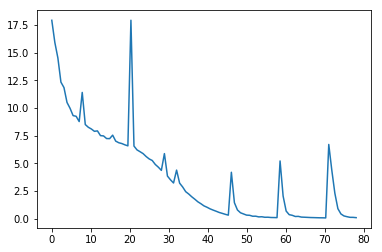

loss on validation set: 0.07768484205007553


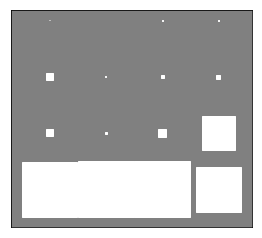

cccc


In [11]:
att = AttentionNetworkWithPrint(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(att, train_set, val_set)
print(att.generate_and_plot_attention('abc'))

79it [00:04, 16.48it/s]


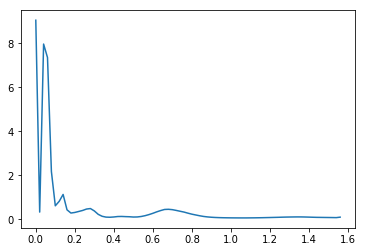

loss on validation set: 0.10574184358119965


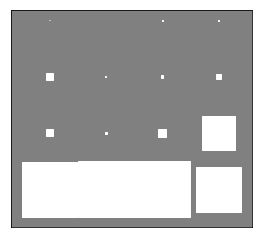

2it [00:00, 16.50it/s]

cccc


79it [00:04, 16.49it/s]


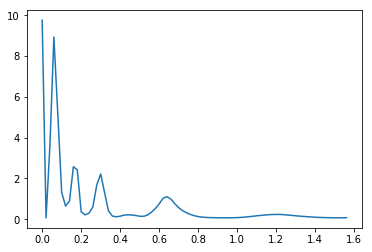

loss on validation set: 0.07589761912822723


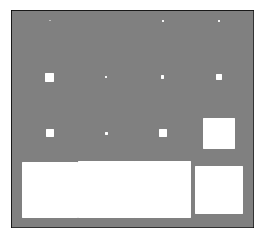

0it [00:00, ?it/s]

cccc


79it [00:04, 16.80it/s]


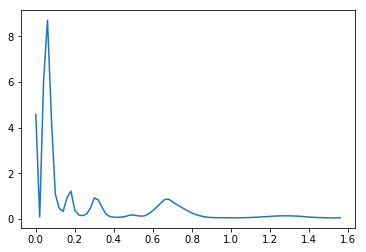

loss on validation set: 0.05629343166947365


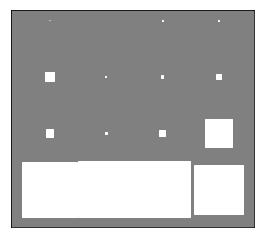

0it [00:00, ?it/s]

cccc


79it [00:04, 16.78it/s]


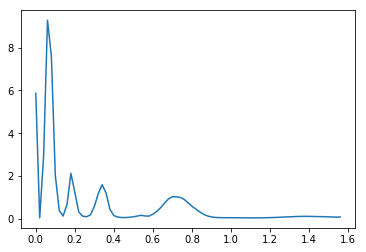

loss on validation set: 0.09390737861394882


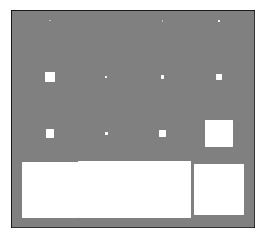

0it [00:00, ?it/s]

cccc


79it [00:04, 16.53it/s]


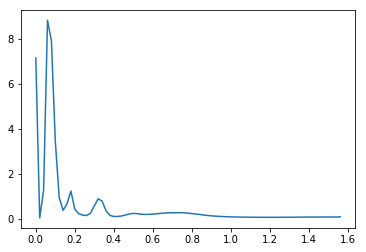

loss on validation set: 0.09460069239139557


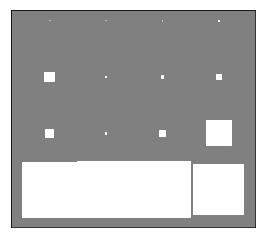

0it [00:00, ?it/s]

cccc


79it [00:04, 16.72it/s]


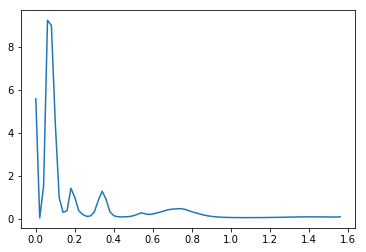

loss on validation set: 0.090845488011837


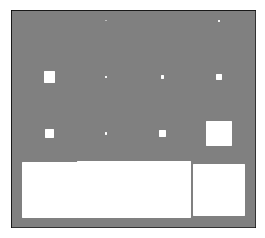

0it [00:00, ?it/s]

cccc


79it [00:04, 16.59it/s]


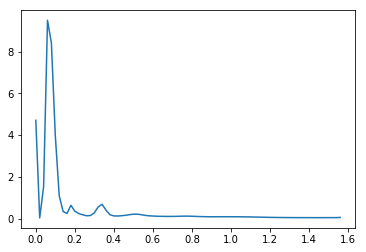

loss on validation set: 0.056650310754776


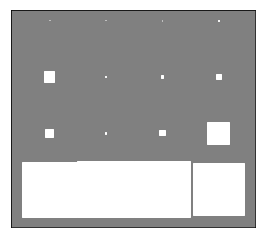

0it [00:00, ?it/s]

cccc


79it [00:04, 16.71it/s]


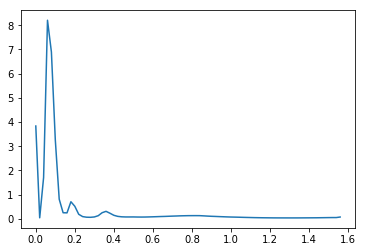

loss on validation set: 0.07112836092710495


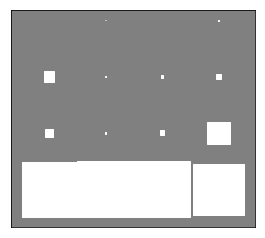

0it [00:00, ?it/s]

cccc


79it [00:04, 16.69it/s]


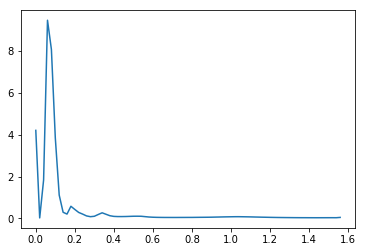

loss on validation set: 0.05045709013938904


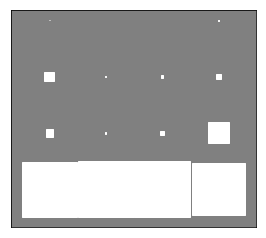

0it [00:00, ?it/s]

cccc


79it [00:04, 16.80it/s]


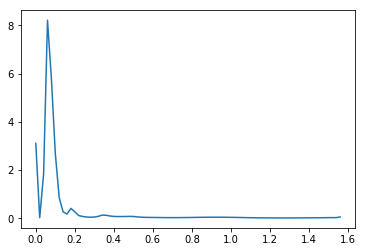

loss on validation set: 0.06006111949682236


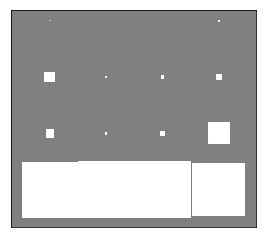

0it [00:00, ?it/s]

cccc


79it [00:04, 16.80it/s]


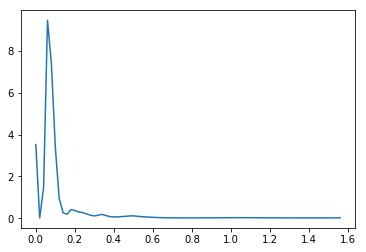

loss on validation set: 0.02672838419675827


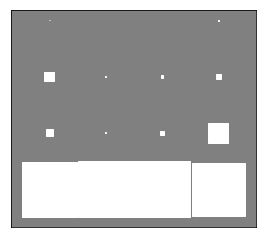

0it [00:00, ?it/s]

cccc


79it [00:04, 16.77it/s]


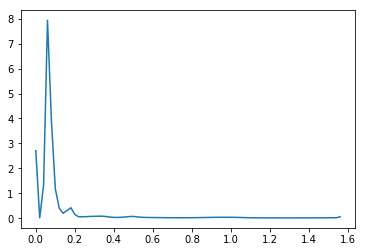

loss on validation set: 0.06057378277182579


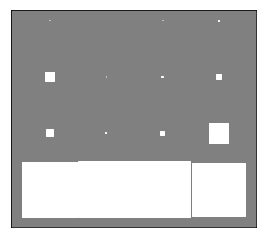

0it [00:00, ?it/s]

cccc


79it [00:04, 16.58it/s]


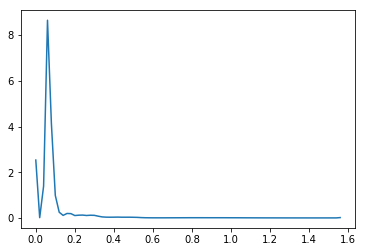

loss on validation set: 0.02394663542509079


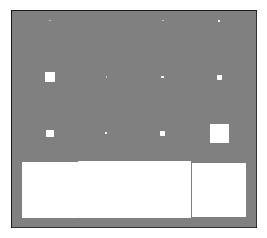

0it [00:00, ?it/s]

cccc


79it [00:04, 16.65it/s]


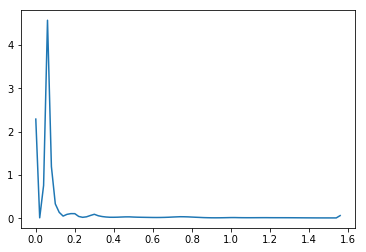

loss on validation set: 0.06042112410068512


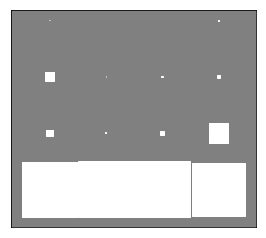

0it [00:00, ?it/s]

cccc


79it [00:04, 16.77it/s]


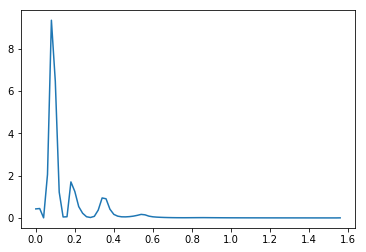

loss on validation set: 0.010644250549376011


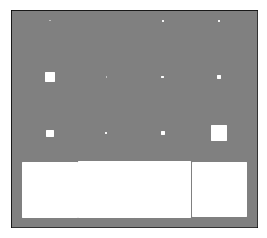

0it [00:00, ?it/s]

cccc


79it [00:05, 15.63it/s]


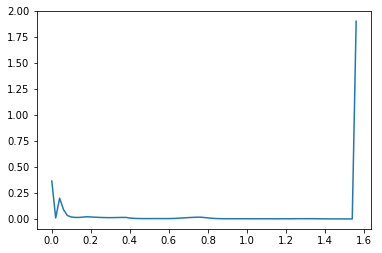

loss on validation set: 1.903038501739502


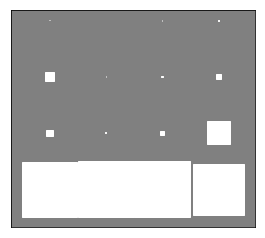

0it [00:00, ?it/s]

cccc


79it [00:04, 15.88it/s]


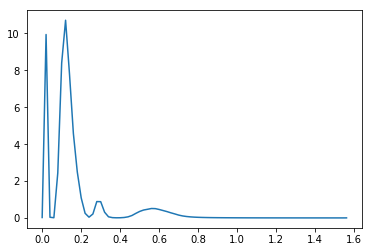

loss on validation set: 0.010109512135386467


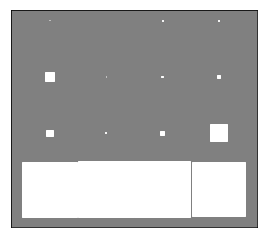

0it [00:00, ?it/s]

cccc


79it [00:04, 16.58it/s]


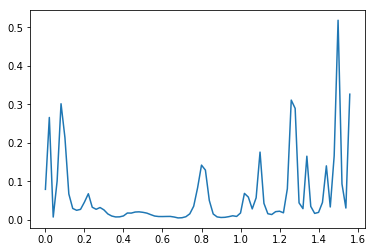

loss on validation set: 0.32658544182777405


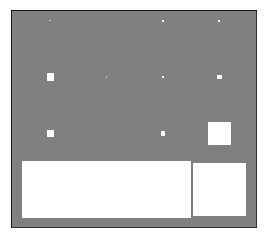

0it [00:00, ?it/s]

cccc


79it [00:04, 15.92it/s]


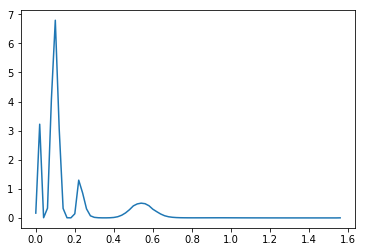

loss on validation set: 0.008693627081811428


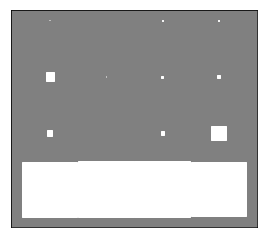

0it [00:00, ?it/s]

cccc


79it [00:04, 16.53it/s]


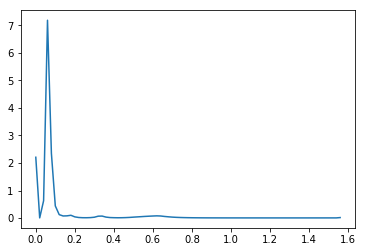

loss on validation set: 0.01770780049264431


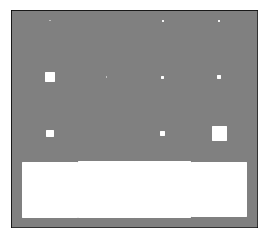

0it [00:00, ?it/s]

cccc


79it [00:05, 15.23it/s]


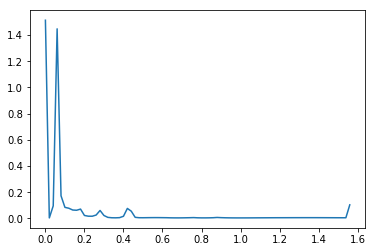

loss on validation set: 0.10368458926677704


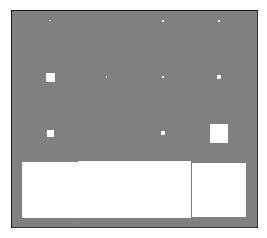

0it [00:00, ?it/s]

cccc


79it [00:04, 16.50it/s]


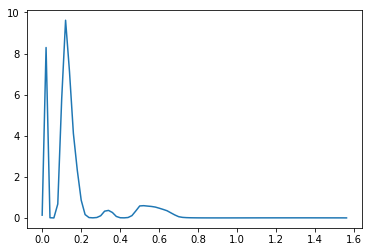

loss on validation set: 0.007037030532956123


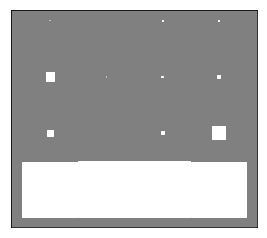

0it [00:00, ?it/s]

cccc


79it [00:04, 16.03it/s]


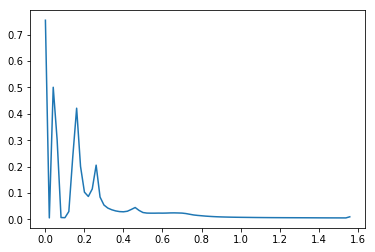

loss on validation set: 0.009923171252012253


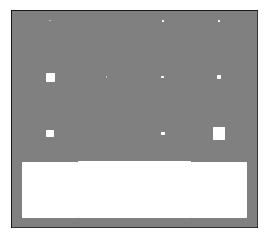

0it [00:00, ?it/s]

cccc


79it [00:04, 16.64it/s]


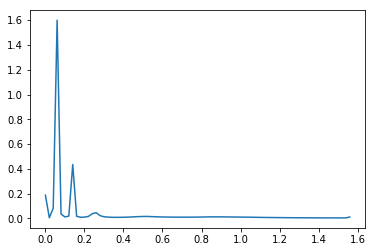

loss on validation set: 0.011816080659627914


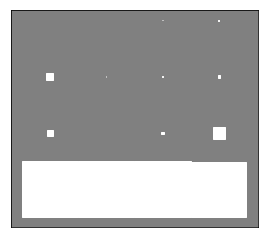

0it [00:00, ?it/s]

cccc


79it [00:04, 16.50it/s]


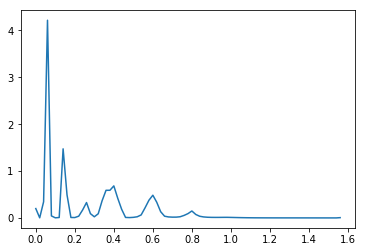

loss on validation set: 0.008863617666065693


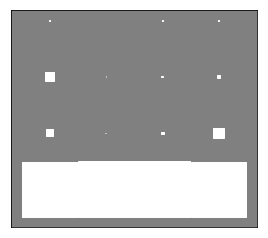

0it [00:00, ?it/s]

cccc


79it [00:04, 16.69it/s]


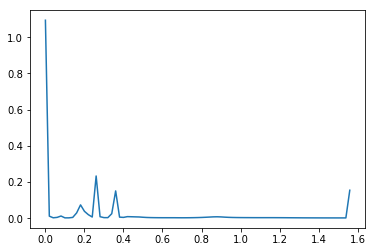

loss on validation set: 0.15491780638694763


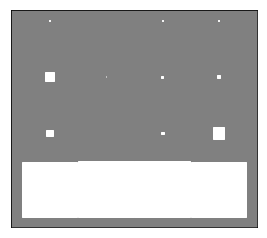

0it [00:00, ?it/s]

cccc


79it [00:04, 16.72it/s]


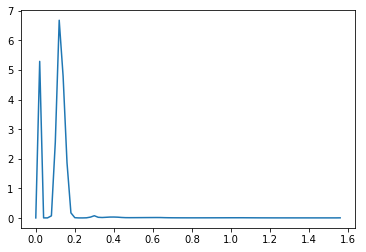

loss on validation set: 0.0058323475532233715


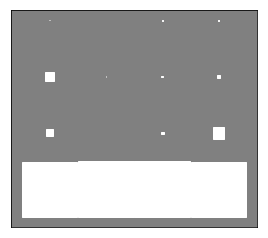

0it [00:00, ?it/s]

cccc


79it [00:04, 16.72it/s]


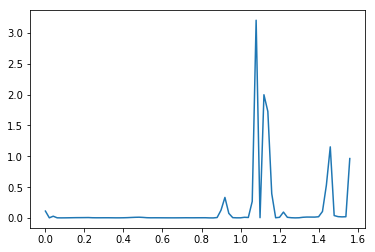

loss on validation set: 0.9638978242874146


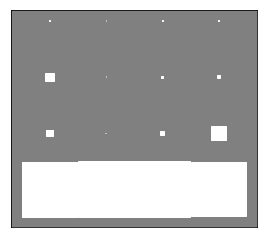

0it [00:00, ?it/s]

cccc


79it [00:04, 16.58it/s]


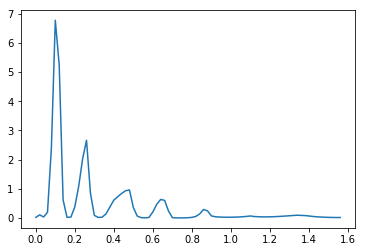

loss on validation set: 0.01613946445286274


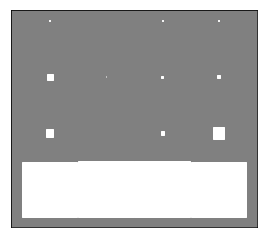

0it [00:00, ?it/s]

cccc


79it [00:04, 16.73it/s]


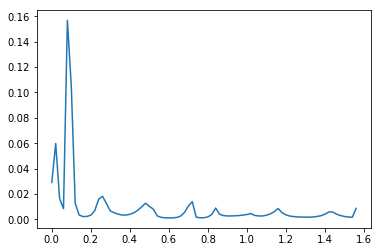

loss on validation set: 0.00864715687930584


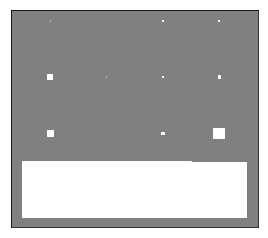

0it [00:00, ?it/s]

cccc


79it [00:04, 16.75it/s]


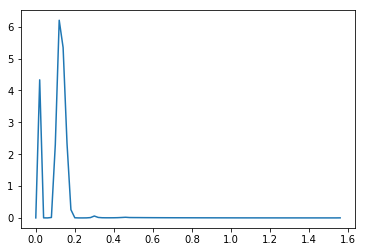

loss on validation set: 0.004060063976794481


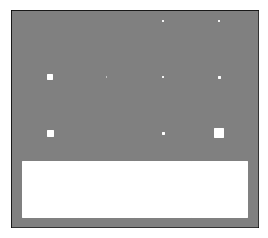

0it [00:00, ?it/s]

cccc


79it [00:04, 16.63it/s]


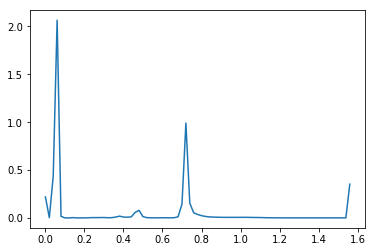

loss on validation set: 0.35316917300224304


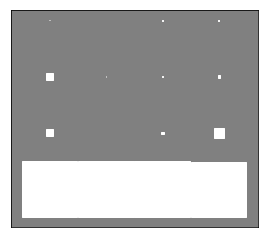

0it [00:00, ?it/s]

cccc


79it [00:04, 16.35it/s]


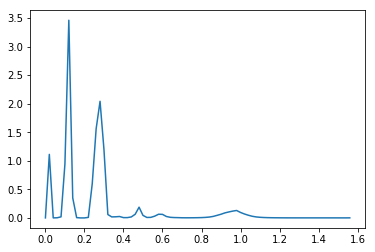

loss on validation set: 0.002712288638576865


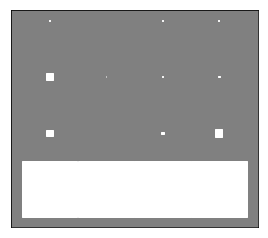

0it [00:00, ?it/s]

cccc


79it [00:05, 15.53it/s]


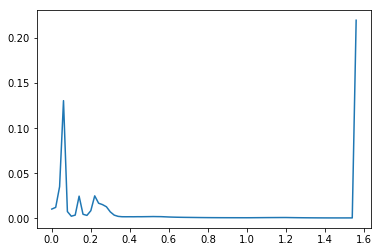

loss on validation set: 0.21970109641551971


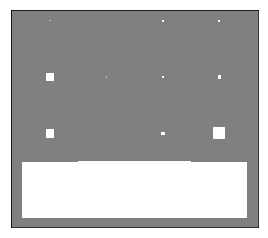

0it [00:00, ?it/s]

cccc


79it [00:04, 16.39it/s]


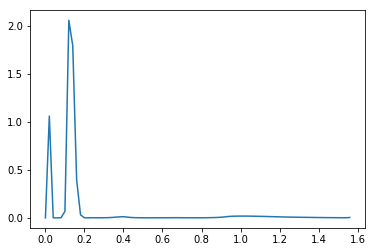

loss on validation set: 0.0050366888754069805


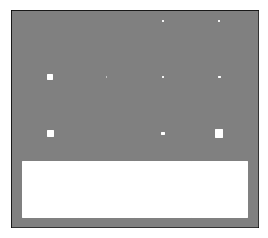

0it [00:00, ?it/s]

cccc


79it [00:04, 16.85it/s]


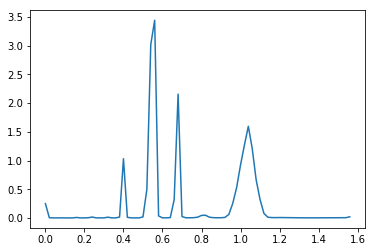

loss on validation set: 0.02047155424952507


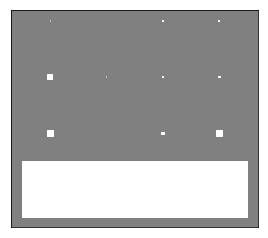

0it [00:00, ?it/s]

cccc


79it [00:04, 16.91it/s]


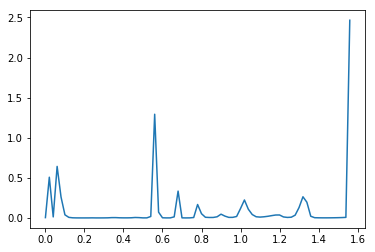

loss on validation set: 2.4657750129699707


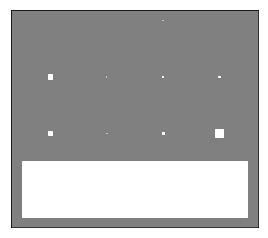

0it [00:00, ?it/s]

cccc


79it [00:04, 16.91it/s]


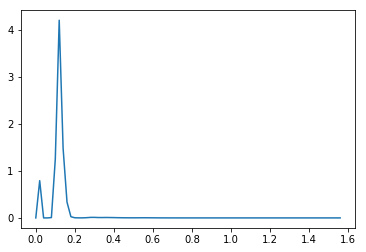

loss on validation set: 0.0011816309997811913


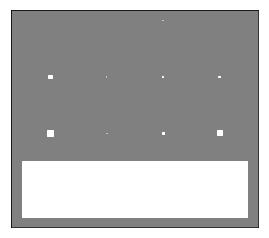

0it [00:00, ?it/s]

cccc


79it [00:04, 17.08it/s]


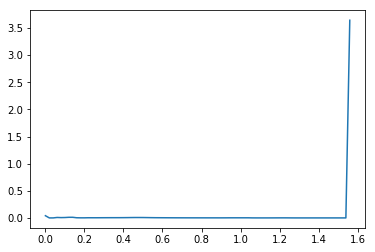

loss on validation set: 3.640695333480835


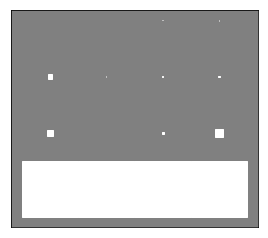

0it [00:00, ?it/s]

cccc


79it [00:04, 17.00it/s]


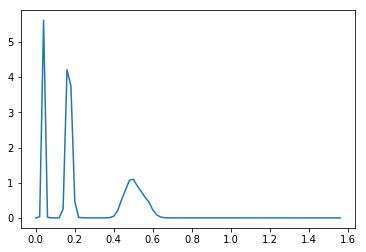

loss on validation set: 0.0014889510348439217


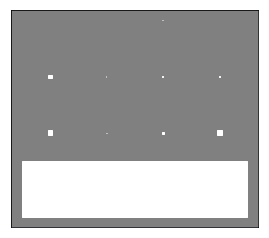

0it [00:00, ?it/s]

cccc


79it [00:04, 16.52it/s]


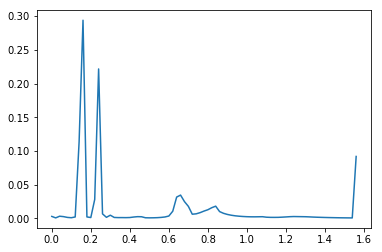

loss on validation set: 0.09184344857931137


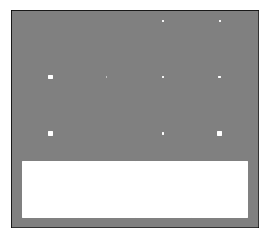

0it [00:00, ?it/s]

cccc


79it [00:04, 16.91it/s]


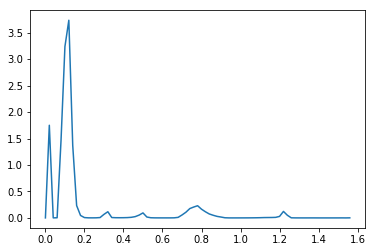

loss on validation set: 0.001976702595129609


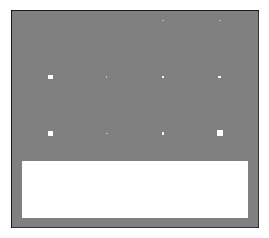

0it [00:00, ?it/s]

cccc


79it [00:04, 16.41it/s]


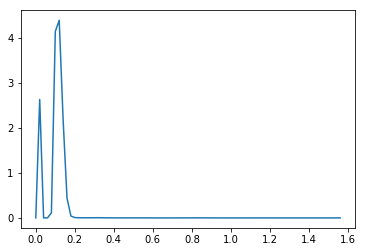

loss on validation set: 0.0012019340647384524


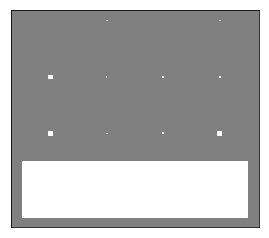

0it [00:00, ?it/s]

cccc


79it [00:04, 16.21it/s]


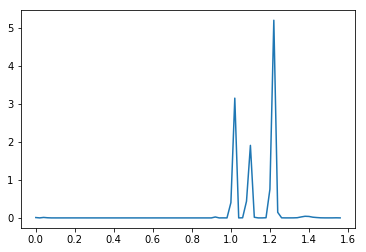

loss on validation set: 0.0010801252210512757


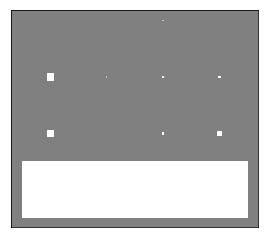

0it [00:00, ?it/s]

cccc


40it [00:02, 16.63it/s]


KeyboardInterrupt: 

In [12]:
while True:
    train(att, train_set, val_set, 1)
    print(att.generate_and_plot_attention('abc'))